In [4]:
# This cell handles the installation and upgrading of Python packages required for the project.
# - 'datasets': For loading and manipulating datasets from Hugging Face.
# - 'evaluate': For using standard evaluation metrics like BLEU and ROUGE.
# - 'rouge_score': Specifically for calculating ROUGE scores.
!pip install -U datasets
!pip install evaluate
!pip install rouge_score

In [5]:
# This cell imports all the essential libraries and sets up the environment.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset, DataLoader
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    GPT2Config,
    Trainer,
    TrainingArguments,
    TextStreamer,
    modeling_outputs,
    trainer_utils,
    AutoTokenizer,
    AutoModelForCausalLM
)

# Datasets library for handling data
from datasets import load_dataset, concatenate_datasets, DatasetDict, Dataset

import ast
import gc
import os
from datetime import datetime
import numpy as np
import evaluate
from sklearn.metrics import f1_score
from torch.amp import autocast

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True

# Utility function to clear GPU cache
def clear_gpu_cache():
    """Collects garbage and empties CUDA cache to free up GPU memory."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# Initial GPU cache clearing and device setup
clear_gpu_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ [STATUS] Ready @ {datetime.now().strftime('%H:%M:%S %d-%m-%Y')}")
print(f"✅ Using device: {device} | TF32 enabled: {torch.backends.cuda.matmul.allow_tf32 if torch.cuda.is_available() else 'N/A'}")

✅ [STATUS] Ready @ 15:56:33 26-05-2025
✅ Using device: cuda | TF32 enabled: True


In [6]:
# These functions are designed to convert different dialogue dataset formats
# into a unified structure with 'context', 'response', and 'source' fields.
def safe_convert_to_list(dialog_str):
    try:
        if not isinstance(dialog_str, str):
            return []
        return ast.literal_eval(dialog_str)
    except (ValueError, SyntaxError):
        return []

def standardize_daily_dialog(example):
    dialog_list = safe_convert_to_list(example.get("dialog"))
    if not dialog_list or len(dialog_list) < 2:
        return None
    return {
        "context": "\n".join(dialog_list[:-1]),
        "response": dialog_list[-1],
        "source": "daily_dialog"
    }

def standardize_flat_persona_chat(example):
    """
    Standardizes examples from a flat PersonaChat dataset structure.
    Context is formed by joining 'history' utterances, and response is the last 'candidate'.
    """
    history = example.get("history", [])
    candidates = example.get("candidates", [])
    # Ensure both history and candidates are non-empty lists
    if not (isinstance(history, list) and history and
            isinstance(candidates, list) and candidates):
        return None
    return {
        "context": "\n".join(history),
        "response": candidates[-1],
        "source": "persona_chat"
    }

In [4]:
# This cell loads the DailyDialog and PersonaChat datasets,
# processes them using the standardization functions, and combines them.

print("\n🔄 Loading and preprocessing datasets...")
dialog_dataset = None  # Initialize to None
try:
    # Load the raw datasets
    daily_dialog_ds = load_dataset("daily_dialog", trust_remote_code=True)
    # PersonaChat dataset with a flat structure
    persona_chat_ds = load_dataset("bavard/personachat_truecased", trust_remote_code=True)

    print(f"Original DailyDialog train columns: {daily_dialog_ds['train'].column_names}")
    print(f"Original PersonaChat train columns: {persona_chat_ds['train'].column_names}")

    # Process DailyDialog dataset
    processed_splits_dd = {}
    for split_name, ds_split in daily_dialog_ds.items():
        # Identify original columns to remove after mapping
        original_dd_cols = [col for col in ['dialog', 'act', 'emotion'] if col in ds_split.column_names]
        mapped_split = ds_split.map(standardize_daily_dialog, remove_columns=original_dd_cols)
        # Filter out any examples that couldn't be standardized (e.g., too short)
        filtered_split = mapped_split.filter(lambda x: x is not None and x.get("context") and x.get("response"))
        processed_splits_dd[split_name] = filtered_split
    print("DailyDialog processed.")

    # Process PersonaChat dataset (flat structure)
    processed_splits_pc = {}
    # Define original columns to be removed from PersonaChat
    original_pc_cols_to_remove = ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx']
    
    for split_name in ["train", "validation"]: # Common splits for PersonaChat
        if split_name in persona_chat_ds:
            ds_split = persona_chat_ds[split_name]
            # Ensure we only try to remove columns that actually exist in the current split
            actual_cols_to_remove_pc = [col for col in original_pc_cols_to_remove if col in ds_split.column_names]
            
            mapped_split = ds_split.map(
                standardize_flat_persona_chat,
                remove_columns=actual_cols_to_remove_pc
            )
            # Filter out any examples that couldn't be standardized
            filtered_split = mapped_split.filter(lambda x: x is not None and x.get("context") and x.get("response"))
            processed_splits_pc[split_name] = filtered_split
    print("PersonaChat processed.")

    # Combine the processed datasets for training and validation
    combined_train_list = [processed_splits_dd["train"]]
    if "train" in processed_splits_pc and len(processed_splits_pc["train"]) > 0:
        combined_train_list.append(processed_splits_pc["train"])
    
    combined_validation_list = [processed_splits_dd["validation"]]
    if "validation" in processed_splits_pc and len(processed_splits_pc["validation"]) > 0:
        combined_validation_list.append(processed_splits_pc["validation"])

    # Ensure we have data to proceed
    if not combined_train_list:
        raise ValueError("No training data available after processing individual datasets.")
    if not combined_validation_list:
        raise ValueError("No validation data available after processing individual datasets.")

    # Concatenate and shuffle the datasets
    final_train_ds = concatenate_datasets(combined_train_list).shuffle(seed=42)
    final_validation_ds = concatenate_datasets(combined_validation_list).shuffle(seed=42)
    # For the test set, we'll use only DailyDialog's test split as PersonaChat might not have a standard test set.
    final_test_ds = processed_splits_dd["test"].shuffle(seed=42)

    # Create the final DatasetDict
    dialog_dataset = DatasetDict({
        "train": final_train_ds,
        "validation": final_validation_ds,
        "test": final_test_ds
    })

    # Apply a final filter for minimum context and response length
    # This helps in removing overly short or potentially noisy examples.
    dialog_dataset = dialog_dataset.filter(
        lambda x: (x.get("context") and isinstance(x["context"], str) and len(x["context"].split()) >= 3 and
                   x.get("response") and isinstance(x["response"], str) and len(x["response"].split()) >= 1)
    )
    print("✅ Final dataset sizes:")
    for split_name_key, ds_val in dialog_dataset.items():
        print(f"- {split_name_key.capitalize()}: {len(ds_val)} examples")
    
    # Print a sample to verify the structure
    if len(dialog_dataset["train"]) > 0:
        print("\nSample training example from combined set:")
        print(dialog_dataset["train"][0])
    else:
        print("WARN: Training set is empty after final processing.")

except Exception as e:
    print(f"❌ Error loading/processing datasets: {e}")
    import traceback
    traceback.print_exc()


🔄 Loading and preprocessing datasets...


README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

personachat_truecased.py:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/5.47k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


personachat_truecased_full_train.json:   0%|          | 0.00/193M [00:00<?, ?B/s]

personachat_truecased_full_valid.json:   0%|          | 0.00/12.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/131438 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7801 [00:00<?, ? examples/s]

Original DailyDialog train columns: ['dialog', 'act', 'emotion']
Original PersonaChat train columns: ['personality', 'candidates', 'history', 'conv_id', 'utterance_idx']


Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11118 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

DailyDialog processed.


Map:   0%|          | 0/131438 [00:00<?, ? examples/s]

Filter:   0%|          | 0/131438 [00:00<?, ? examples/s]

Map:   0%|          | 0/7801 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7801 [00:00<?, ? examples/s]

PersonaChat processed.


Filter:   0%|          | 0/131438 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7801 [00:00<?, ? examples/s]

✅ Final dataset sizes:
- Train: 131319 examples
- Validation: 7801 examples
- Test: 0 examples

Sample training example from combined set:
{'context': 'Hi how are you doing?\nGood, watching the latest episode of face off. Seen it?\nNo, what is that show about?', 'response': "Special effects competition. I've to make cookies for the bake sale after.", 'source': 'persona_chat'}


In [7]:
# This cell analyzes the distribution of token lengths in the training dataset.
# This information is crucial for selecting an appropriate 'max_length' for tokenization,
# balancing sequence coverage with computational efficiency and memory constraints.

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # For a nice progress bar

# Ensure tokenizer and dialog_dataset are loaded from previous cells.
# If not, this cell will indicate that they are missing.

if 'dialog_dataset' in locals() and 'train' in dialog_dataset and \
   'tokenizer' in locals() and dialog_dataset["train"] is not None and len(dialog_dataset["train"]) > 0:

    print("Analyzing token lengths for dialog_dataset['train']...")

    token_lengths = []
    
    # We'll analyze the entire training dataset.
    # For very large datasets, one might consider sampling for speed, e.g.:
    # sample_size = 20000
    # dataset_to_analyze = dialog_dataset["train"].select(range(min(sample_size, len(dialog_dataset["train"]))))
    # print(f"Analyzing the first {len(dataset_to_analyze)} samples for token length distribution...")
    dataset_to_analyze = dialog_dataset["train"]


    # Iterate through the dataset and calculate token lengths
    for example in tqdm(dataset_to_analyze, desc="Calculating token lengths"):
        context = example.get("context", "")
        response = example.get("response", "")
        
        # Ensure context and response are strings
        context_str = str(context) if context is not None else ""
        response_str = str(response) if response is not None else ""
        
        # Construct the full text as it would be fed to the model: Context_EOS_Response_EOS
        full_text = context_str + tokenizer.eos_token + response_str + tokenizer.eos_token
        
        # tokenizer.encode() is efficient for just getting token IDs to determine length
        tokenized_ids = tokenizer.encode(full_text) 
        token_lengths.append(len(tokenized_ids))

    if not token_lengths:
        print("No token lengths were calculated. Ensure the dataset is not empty and processing is correct.")
    else:
        lengths_np = np.array(token_lengths)

        # Print descriptive statistics
        print("\n--- Token Length Statistics ---")
        print(f"Number of samples analyzed: {len(lengths_np)}")
        print(f"Min length:    {lengths_np.min()}")
        print(f"Max length:    {lengths_np.max()}")
        print(f"Mean length:   {lengths_np.mean():.2f}")
        print(f"Median length: {np.median(lengths_np):.2f}")

        # Print percentiles to understand distribution
        print("\n--- Percentiles ---")
        percentiles_to_check = [50, 75, 80, 90, 95, 98, 99, 99.5]
        for p in percentiles_to_check:
            val = np.percentile(lengths_np, p)
            print(f"{p}th percentile: {val:.2f} tokens")
            if p == 90:
                print(f"    (Meaning 90% of sequences are shorter than or equal to ~{int(val)} tokens)")

        print("\n--- Interpretation for max_length ---")
        # Get the theoretical max length of the tokenizer's underlying model
        # Note: tokenizer.model_max_length might be very large (e.g., 1e30) if not explicitly set for some models.
        # GPT2-like models typically have max_position_embeddings of 1024.
        # If tokenizer is from a saved custom model, it might inherit model_max_length from its config.
        # Using a practical check like tokenizer.name_or_path and config.max_position_embeddings if needed.
        try:
            # Attempt to get model_max_length from tokenizer first
            max_model_len = tokenizer.model_max_length
            if max_model_len > 2048: # Heuristic for models where it's not practically set
                print(f"Tokenizer's model_max_length ({max_model_len}) is very large. Checking config for {MODEL_NAME} (distilgpt2 default is 1024).")
                temp_config = GPT2Config.from_pretrained(MODEL_NAME if MODEL_NAME else "distilgpt2")
                max_model_len = temp_config.max_position_embeddings
        except:
             # Fallback for base model if tokenizer path is custom
            temp_config = GPT2Config.from_pretrained(MODEL_NAME if MODEL_NAME else "distilgpt2")
            max_model_len = temp_config.max_position_embeddings
        print(f"The base model's ({tokenizer.name_or_path}) theoretical max sequence length is: {max_model_len}")


        # Show coverage for different potential max_length settings
        print("\nCoverage for potential max_length values:")
        potential_max_lengths = [128, 256, 384, 512, 768, 1024]
        current_coverage_256 = 0 # Initialize
        for l_val in potential_max_lengths:
            if l_val > max_model_len:
                print(f"- {l_val} tokens: Exceeds model's max_position_embeddings ({max_model_len}). Not recommended without architectural changes or position embedding extension.")
                continue
            
            num_covered = np.sum(lengths_np <= l_val)
            percentage_covered = (num_covered / len(lengths_np)) * 100
            print(f"- {l_val} tokens: Covers {percentage_covered:.2f}% of your analyzed training samples.")
            if l_val == 256:
                current_coverage_256 = percentage_covered # Store for comparison
            if l_val == 512 and current_coverage_256 > 0: # Compare with 256 if available
                print(f"    (Compared to {l_val}: {percentage_covered:.2f}% vs {current_coverage_256:.2f}% for max_length=256)")

        # Plotting a histogram for visual analysis
        plt.figure(figsize=(12, 6))
        plt.hist(lengths_np, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('Histogram of Tokenized Sequence Lengths (Context + EOS + Response + EOS)')
        plt.xlabel('Token Length')
        plt.ylabel('Number of Samples')
        plt.grid(axis='y', alpha=0.75)
        
        # Add vertical lines for common max_length choices like 256 and 512
        lines_plotted = False
        if lengths_np.max() > 0 : # only plot if there's data
            common_lengths_to_mark = [l for l in [256, 512] if l < lengths_np.max()]
            for length_mark in common_lengths_to_mark:
                plt.axvline(length_mark, color='red', linestyle='dashed', linewidth=1.5, 
                            label=f'max_length = {length_mark}')
                lines_plotted = True
        if lines_plotted: # Add legend only if lines were actually added
             plt.legend()
        
        plt.show()
else:
    print("❌ `dialog_dataset` or `tokenizer` not found, or `dialog_dataset['train']` is empty.")
    print("Please ensure they are loaded and defined correctly from the preceding cells to perform token length analysis.")

❌ `dialog_dataset` or `tokenizer` not found, or `dialog_dataset['train']` is empty.
Please ensure they are loaded and defined correctly from the preceding cells to perform token length analysis.


In [8]:
# Here, we load the GPT-2 tokenizer which will be used for converting text data into
# a format understandable by the model (tokens). 'distilgpt2' is chosen as a base.
# We also ensure a padding token is set, which is crucial for batching sequences of varying lengths.

MODEL_NAME = "distilgpt2" # Using DistilGPT-2 as the base model/tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(MODEL_NAME, use_fast=True)

# GPT-2 models don't have a default pad_token. It's common practice to set it to the eos_token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    print(f"Set pad_token to eos_token (ID: {tokenizer.eos_token_id}) for tokenizer '{MODEL_NAME}'.")

print(f"\n✅ Tokenizer loaded. Pad token ID: {tokenizer.pad_token_id}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Set pad_token to eos_token (ID: 50256) for tokenizer 'distilgpt2'.

✅ Tokenizer loaded. Pad token ID: 50256


In [9]:
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads=4, dropout_prob=0.1):
        super().__init__()
        assert hidden_size % num_heads == 0, "Hidden size must be divisible by num_heads"
        self.hidden_size = hidden_size
        self.num_heads = num_heads # This will be config.n_head from SelfAttentiveModel
        self.head_size = hidden_size // num_heads
        self.dropout_prob = dropout_prob

        self.qkv = nn.Linear(hidden_size, hidden_size * 3)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.scale = self.head_size ** -0.5

    def forward(self, x, attention_mask=None): # x shape: (B, L_x, H)
        B, L_x, H = x.shape 
        
        qkv_out = self.qkv(x) # (B, L_x, 3 * H)
        qkv_out = qkv_out.reshape(B, L_x, 3, self.num_heads, self.head_size) # (B, L_x, 3, num_heads, head_size)
        qkv_out = qkv_out.permute(2, 0, 3, 1, 4) # (3, B, num_heads, L_x, head_size)
        q, k, v = qkv_out[0], qkv_out[1], qkv_out[2] # Each is (B, num_heads, L_x, head_size)

        # --- Forcing manual attention path to bypass previous SDPA error and current matmul error's complexity ---
        # The matmul error happens in this manual path if attention_mask's length doesn't match x's length.
        # The fix is in SelfAttentiveModel's forward to pass the correct mask slice.
        
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale # (B, num_heads, L_x, L_x)
        
        if attention_mask is not None:
            # attention_mask here is expected to be (B, L_x)
            additive_mask = (1.0 - attention_mask[:, None, None, :].to(scores.dtype)) * -1e9 
            scores = scores + additive_mask 
            
        attn_probs = F.softmax(scores, dim=-1)
        attn_probs = self.dropout(attn_probs)
        attn_output = torch.matmul(attn_probs, v) # (B, num_heads, L_x, head_size)
            
        attn_output = attn_output.transpose(1, 2).contiguous().reshape(B, L_x, self.hidden_size)
        return self.dense(attn_output)


class SelfAttentiveModel(GPT2LMHeadModel):
    def __init__(self, config):
        super().__init__(config)
        # Use n_head from GPT2Config for consistency
        self.custom_self_attention = SelfAttention(config.n_embd, num_heads=config.n_head) 
        self.attention_dropout = nn.Dropout(0.1) 

        # Initialize weights for the custom layers (good practice)
        self._init_weights(self.custom_self_attention.qkv)
        self._init_weights(self.custom_self_attention.dense)
        print(f"SelfAttentiveModel initialized with {config.n_head} heads for custom attention.")

    def forward(
        self,
        input_ids=None,
        past_key_values=None,
        attention_mask=None, # This is the cumulative attention mask (B, full_seq_len) from generate()
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        labels=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None, 
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        
        transformer_outputs = self.transformer(
            input_ids,
            past_key_values=past_key_values,
            attention_mask=attention_mask, # Original full attention mask for the base transformer
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=True, 
            return_dict=True, 
        )
        # last_hidden_state has shape (B, cur_input_seq_len, H)
        # When use_cache=True (default in generate), cur_input_seq_len is 1 after the first step (prefill).
        last_hidden_state = transformer_outputs.last_hidden_state 
        
        # Determine the correct attention_mask for the custom_self_attention layer.
        # It should match the sequence length of `last_hidden_state`.
        # `attention_mask` from the `generate` utility is cumulative for the whole sequence.
        
        current_seq_len_of_hidden_state = last_hidden_state.shape[1]
        mask_for_custom_layer = None
        if attention_mask is not None:
            if attention_mask.shape[1] > current_seq_len_of_hidden_state:
                # This occurs during generation steps after prefill.
                # `last_hidden_state` is for the current token(s) (e.g., seq_len 1 for single token generation),
                # but `attention_mask` is for the whole sequence up to now.
                # We take the last part of the full `attention_mask` corresponding to the current token(s).
                mask_for_custom_layer = attention_mask[:, -current_seq_len_of_hidden_state:]
            else:
                # This occurs during the first step (prefill) or if not using cache.
                mask_for_custom_layer = attention_mask
        
        # Pass last_hidden_state and its corresponding attention_mask slice
        custom_attn_output = self.custom_self_attention(last_hidden_state, attention_mask=mask_for_custom_layer)
        custom_attn_output = self.attention_dropout(custom_attn_output)
        
        lm_logits = self.lm_head(custom_attn_output)

        loss = None
        if labels is not None:
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        if not return_dict:
            # For compatibility, though trainer and generate prefer return_dict=True
            out_tuple = (lm_logits,)
            if transformer_outputs.past_key_values is not None:
                 out_tuple += (transformer_outputs.past_key_values,)
            # Append all hidden states (base + custom) and attentions
            out_tuple += (transformer_outputs.hidden_states + (custom_attn_output,),) 
            if transformer_outputs.attentions is not None:
                out_tuple += (transformer_outputs.attentions,)
            return ((loss,) + out_tuple) if loss is not None else out_tuple

        return modeling_outputs.CausalLMOutputWithPast(
            loss=loss,
            logits=lm_logits,
            past_key_values=transformer_outputs.past_key_values, 
            hidden_states=transformer_outputs.hidden_states + (custom_attn_output,), 
            attentions=transformer_outputs.attentions, 
        )

print("\n✅ Custom SelfAttentiveModel and SelfAttention model defined.")


✅ Custom SelfAttentiveModel and SelfAttention model defined.


In [20]:
# This class defines how individual examples from our processed dataset are
# converted into tokenized inputs suitable for training the model.
# It handles formatting (context EOS response EOS) and tokenization.

class DialogueDataset(TorchDataset):
    def __init__(self, hf_dataset, tokenizer, max_length=256):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        context = item.get("context", "")
        response = item.get("response", "")
        
        context_str = str(context) if context is not None else ""
        response_str = str(response) if response is not None else ""

        # Construct the text input for the model: context, EOS token, response, EOS token
        text = context_str + self.tokenizer.eos_token + response_str + self.tokenizer.eos_token
        
        # Tokenize the combined text
        tokenized_output = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",    # Pad shorter sequences to max_length
            truncation=True,         # Truncate longer sequences
            return_tensors="pt"      # Return PyTorch tensors
        )
        # Squeeze to remove the batch dimension (as __getitem__ returns a single item)
        input_ids = tokenized_output["input_ids"].squeeze(0)
        attention_mask = tokenized_output["attention_mask"].squeeze(0)

        # For language modeling, labels are typically the same as input_ids
        # The model itself handles shifting for Causal LM.
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": input_ids.clone() # Important to clone for labels
        }

# Create instances of DialogueDataset for train, validation, and test sets
train_dialogue_dataset, val_dialogue_dataset, test_dialogue_dataset = None, None, None
if dialog_dataset and "train" in dialog_dataset and len(dialog_dataset["train"]) > 0:
    # Max length of 256 was determined from token length analysis (covers >99% of samples)
    train_dialogue_dataset = DialogueDataset(dialog_dataset["train"], tokenizer, max_length=256)
    val_dialogue_dataset = DialogueDataset(dialog_dataset["validation"], tokenizer, max_length=256)
    test_dialogue_dataset = DialogueDataset(dialog_dataset["test"], tokenizer, max_length=256)
    print(f"\n✅ PyTorch Datasets created. Train samples: {len(train_dialogue_dataset)}")
    
    # Check a sample item from the PyTorch dataset
    if len(train_dialogue_dataset) > 0:
      sample_item = train_dialogue_dataset[0]
      print("Sample tokenized input_ids length:", len(sample_item["input_ids"]))
      assert len(sample_item["input_ids"]) == 256, "Tokenized sample length mismatch!"
else:
    # This block executes if the Hugging Face dataset wasn't loaded or is empty
    print("❌ Skipping PyTorch Dataset creation due to empty or failed dialog_dataset.")
    if dialog_dataset and "train" in dialog_dataset :
          print(f"Debug: dialog_dataset['train'] length is {len(dialog_dataset['train'])}\")")
    elif dialog_dataset:
        print("Debug: dialog_dataset exists but dialog_dataset['train'] does not or is problematic.")
    else:
        print("Debug: dialog_dataset is None.")


✅ PyTorch Datasets created. Train samples: 131319
Sample tokenized input_ids length: 256


In [10]:
# This cell loads the BLEU and ROUGE metrics from the 'evaluate' library.
# These are standard metrics for evaluating the quality of generated text in dialogue systems.

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
print("\n✅ Metrics setup complete (BLEU, ROUGE loaded).")
# Note: These metrics are typically used in a compute_metrics function within the Trainer,
# but loading them here ensures they are available.


✅ Metrics setup complete (BLEU, ROUGE loaded).


In [38]:
# This cell defines the main function 'train_chatbot_model' which sets up
# the TrainingArguments and the Trainer from Hugging Face to handle the model training process.
# It also includes logic for resuming from checkpoints.

# Define output directories for the model and logs
# Using a more descriptive name for the output directory, perhaps indicating number of epochs.
OUTPUT_DIR = "./self_attentive_chatbot_model_epochs_3"
LOGGING_DIR = "./chatbot_logs_epochs_3"

# Utility function to clear GPU cache (re-defined for encapsulation if cell is run standalone)
def clear_gpu_cache():
    import gc
    import torch
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

def train_chatbot_model(model_to_train, train_ds, val_ds, custom_tokenizer, output_dir, logging_dir):
    """
    Trains the chatbot model using the Hugging Face Trainer.
    
    Args:
        model_to_train: The model instance to be trained.
        train_ds: The training DialogueDataset.
        val_ds: The validation DialogueDataset.
        custom_tokenizer: The tokenizer used for the model.
        output_dir: Directory to save model checkpoints and final model.
        logging_dir: Directory to save training logs for TensorBoard.
    
    Returns:
        The trained Hugging Face Trainer instance.
    """
    fp16_enabled = torch.cuda.is_available()

    last_checkpoint = None
    if os.path.isdir(output_dir):
        last_checkpoint = trainer_utils.get_last_checkpoint(output_dir)
    
    if last_checkpoint:
        print(f"✅ Resuming training from checkpoint: {last_checkpoint}")
    else:
        print("ℹ️ No checkpoint found. Starting fresh training run.")

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True if not last_checkpoint else False,
        num_train_epochs=5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=8,
        learning_rate=3e-5,           
        weight_decay=0.01,            
        warmup_ratio=0.1,             
        lr_scheduler_type='cosine',   
        logging_dir=logging_dir,      
        logging_strategy="steps",
        logging_steps=1000,           
        eval_strategy="epoch",        
        save_strategy="epoch",        
        load_best_model_at_end=True,  
        metric_for_best_model="eval_loss",
        greater_is_better=False,     
        fp16=fp16_enabled,           
        bf16=False,                  
        optim="adamw_torch",         
        dataloader_num_workers=2,    
        dataloader_pin_memory=True,  
        report_to="tensorboard",     
        remove_unused_columns=True,  
    )
    
    # Initialize the Trainer
    trainer = Trainer(
        model=model_to_train,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=custom_tokenizer, # Pass tokenizer for padding and attention mask handling if needed by Trainer
        # You might add a compute_metrics function here if evaluating BLEU/ROUGE during training
    )
    
    print("\n🚀 Starting model training...")
    clear_gpu_cache() # Clear GPU cache before starting training

    # Start training (or resume if last_checkpoint is found)
    train_result = trainer.train(resume_from_checkpoint=last_checkpoint)
    
    print("✅ Training complete.")
    
    # Save the final best model and tokenizer
    trainer.save_model(output_dir) 
    custom_tokenizer.save_pretrained(output_dir)
    print(f"✅ Best model (or final model if no improvement) saved to {output_dir}")
    print(f"Training stats: {train_result.metrics}")
    
    return trainer

print("Trainer function 'train_chatbot_model' is defined and ready.")

Trainer loaded.


In [32]:
# This block serves as the main entry point for training the SelfAttentiveModel.
# It initializes the model, loads pre-trained GPT-2 weights (if not resuming),
# resizes token embeddings if necessary, and then calls the training function.
# After training, it evaluates the model on the test set.

# This check ensures the code runs only when the script is executed directly (not imported as a module)
# and also that the necessary datasets have been successfully created.
if __name__ == "__main__":

    if 'train_dialogue_dataset' in locals() and train_dialogue_dataset and \
       'val_dialogue_dataset' in locals() and val_dialogue_dataset:
        
        print(f"\n🔄 Initializing SelfAttentiveModel for training run targeting: {OUTPUT_DIR}")
        # Load the configuration for GPT-2 (distilgpt2 in this case)
        config = GPT2Config.from_pretrained(MODEL_NAME) 
        # Ensure the pad_token_id in the config matches our tokenizer's pad_token_id
        config.pad_token_id = tokenizer.pad_token_id
        
        # Instantiate our custom SelfAttentiveModel
        model = SelfAttentiveModel(config).to(device) 
        
        # If not resuming from a checkpoint, load weights from the base GPT-2 model
        # This provides a good starting point for fine-tuning.
        if not trainer_utils.get_last_checkpoint(OUTPUT_DIR):
            print("Attempting to load base GPT-2 weights for a fresh start...")
            try:
                # Load a standard GPT2LMHeadModel with the same config
                base_gpt2_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME, config=config)
                # Load its state_dict into our custom model. `strict=False` allows for
                # mismatches if our custom model has extra/different layers (like custom_self_attention).
                model.load_state_dict(base_gpt2_model.state_dict(), strict=False) 
                print("✅ Loaded pretrained GPT-2 weights into custom model for fresh start.")
                del base_gpt2_model # Free up memory
            except Exception as e:
                print(f"Could not load base GPT-2 weights: {e}. Model will train from scratch or from existing checkpoint if found later.")
        clear_gpu_cache()

        # Resize token embeddings if the tokenizer vocabulary size is larger than the model's.
        # This can happen if special tokens were added to the tokenizer.
        if len(tokenizer) > model.config.vocab_size:
            print(f"Resizing token embeddings from {model.config.vocab_size} to {len(tokenizer)}")
            model.resize_token_embeddings(len(tokenizer))

        # Call the training function
        trainer_instance = train_chatbot_model(
            model, 
            train_dialogue_dataset, 
            val_dialogue_dataset, 
            tokenizer, 
            OUTPUT_DIR, 
            LOGGING_DIR
        )

        # --- Evaluation on the test set after training is complete ---
        # Check if a trainer instance exists and if the test dataset is available and non-empty
        if trainer_instance and 'test_dialogue_dataset' in locals() and test_dialogue_dataset and len(test_dialogue_dataset) > 0:
            print("\n🧪 Evaluating the best model on the test set...")
            clear_gpu_cache() 
            # The trainer by default uses the best model loaded at the end if load_best_model_at_end=True
            test_results = trainer_instance.evaluate(test_dialogue_dataset, metric_key_prefix="test") # Add prefix for clarity in logs
            print(f"✅ Test set evaluation results: {test_results}")
            
            # Save test results to a file
            try:
                test_results_path = os.path.join(OUTPUT_DIR, "test_results.json")
                import json
                with open(test_results_path, "w") as f:
                    json.dump(test_results, f, indent=4)
                print(f"Test results saved to {test_results_path}")
            except Exception as e:
                print(f"Could not save test results: {e}")

        elif 'test_dialogue_dataset' in locals() and test_dialogue_dataset and len(test_dialogue_dataset) == 0:
            print("ℹ️ Skipping test set evaluation because the test dataset is empty.")
        else:
            print("ℹ️ Skipping test set evaluation as trainer_instance or test_dialogue_dataset might not be available/valid.")
    else:
        # This executes if the required datasets (train_dialogue_dataset or val_dialogue_dataset) are not found.
        print("❌ Skipping training and evaluation as PyTorch datasets (train or validation) were not created successfully.")
        print("   Please ensure the preceding cells for data loading and preparation have run correctly.")


🔄 Initializing SelfAttentiveModel model for training run targeting: ./dialogpt_small_self_attentive_model
SelfAttentiveModel initialized with 12 heads for custom attention.
Attempting to load base GPT-2 weights for a fresh start...
✅ Loaded pretrained GPT-2 weights into custom model for fresh start.
ℹ️ No checkpoint found. Starting fresh training.

🚀 Starting model training...


/tmp/ipykernel_35/1974942987.py:53: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Exception ignored in: <function _xla_gc_callback at 0x79a8dce4d120>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [11]:
# This cell demonstrates how to load the model that was trained and saved in the previous steps,
# specifically from a checkpoint, for interactive chatting.

print("\n🔄 Loading the fine-tuned SelfAttentiveModel for an interactive chat session...")
TRAINED_MODEL_CHECKPOINT_DIR = "./self_attentive_chatbot_model_epochs_3/checkpoint-10255" 

# Initialize tokenizer and model variables
chat_tokenizer = None
chat_model_self_attentive = None # Renamed to avoid conflict with other chat_model variables

try:
    # Load tokenizer from the saved model directory
    print(f"Loading tokenizer from: {TRAINED_MODEL_CHECKPOINT_DIR}")
    chat_tokenizer = GPT2Tokenizer.from_pretrained(TRAINED_MODEL_CHECKPOINT_DIR)
    if chat_tokenizer.pad_token is None: # Ensure pad token is set
        chat_tokenizer.pad_token = chat_tokenizer.eos_token
        print(f"Set pad_token to eos_token (ID: {chat_tokenizer.eos_token_id}) for loaded tokenizer.")
    print("✅ Tokenizer loaded successfully from saved model directory.")

    # Load the model configuration first
    print(f"Loading model configuration from: {TRAINED_MODEL_CHECKPOINT_DIR}")
    config = GPT2Config.from_pretrained(TRAINED_MODEL_CHECKPOINT_DIR)
    # Ensure pad_token_id is correctly set in the config for generation
    if config.pad_token_id is None:
        config.pad_token_id = chat_tokenizer.eos_token_id
        print(f"Set config.pad_token_id to {config.pad_token_id}")

    # Load the custom SelfAttentiveModel using .from_pretrained with the specific checkpoint and config
    print(f"Loading SelfAttentiveModel weights from: {TRAINED_MODEL_CHECKPOINT_DIR}")
    chat_model_self_attentive = SelfAttentiveModel.from_pretrained(TRAINED_MODEL_CHECKPOINT_DIR, config=config)
    chat_model_self_attentive.to(device) # Move model to the configured device (GPU or CPU)
    chat_model_self_attentive.eval()     # Set the model to evaluation mode (disables dropout, etc.)
    print(f"✅ Custom SelfAttentiveModel loaded successfully from {TRAINED_MODEL_CHECKPOINT_DIR}")
    clear_gpu_cache() # Clear GPU cache after loading

except Exception as e:
    print(f"❌ Error loading the trained SelfAttentiveModel from {TRAINED_MODEL_CHECKPOINT_DIR}: {e}")
    print("   Please ensure: ")
    print(f"     1. The path '{TRAINED_MODEL_CHECKPOINT_DIR}' is correct.")
    print("     2. Training has completed and saved a model/checkpoint at that location.")
    print("     3. The SelfAttention and SelfAttentiveModel classes are defined in the current session.")
    chat_model_self_attentive = None # Ensure it's None if loading failed


🔄 Loading the fine-tuned SelfAttentiveModel for an interactive chat session...
Loading tokenizer from: ./self_attentive_chatbot_model_epochs_3/checkpoint-10255
✅ Tokenizer loaded successfully from saved model directory.
Loading model configuration from: ./self_attentive_chatbot_model_epochs_3/checkpoint-10255
Loading SelfAttentiveModel weights from: ./self_attentive_chatbot_model_epochs_3/checkpoint-10255
SelfAttentiveModel initialized with 12 heads for custom attention.
✅ Custom SelfAttentiveModel loaded successfully from ./self_attentive_chatbot_model_epochs_3/checkpoint-10255


In [12]:
# This cell allows you to chat with the SelfAttentiveModel that you loaded from your checkpoint.

# Check if the chat_model_self_attentive was successfully loaded in the previous cell
if 'chat_model_self_attentive' in locals() and chat_model_self_attentive is not None and \
   'chat_tokenizer' in locals() and chat_tokenizer is not None:
    
    print("\n🤖 Your Self-Attentive Chatbot is ready! Type 'exit' or 'quit' to end.")
    clear_gpu_cache() # Good practice to clear cache before intensive tasks
    
    # streamer_self_attentive = TextStreamer(chat_tokenizer, skip_prompt=True) # Optional: for streaming output

    # Loop for interactive chat
    for chat_step in range(5): # Let's limit to 5 interactions for this demonstration
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            print("🤖 Goodbye from your Self-Attentive Chatbot!")
            break
        if not user_input.strip(): # Skip empty input
            continue
        
        # Prepare the input for the model: UserInput + EOS_Token
        prompt = user_input + chat_tokenizer.eos_token
        inputs = chat_tokenizer(prompt, return_tensors="pt").to(device) # Tokenize and move to device
        
        # Generate a response from the model
        with torch.no_grad(): # Disable gradient calculations for inference
            generated_ids = chat_model_self_attentive.generate(
                inputs["input_ids"], 
                attention_mask=inputs["attention_mask"],
                max_new_tokens=70,          # Maximum number of new tokens to generate
                num_beams=1,                # Using 1 for sampling. Increase for beam search (e.g., 3 or 5)
                do_sample=True,             # Enable sampling
                top_k=50,                   # Consider top_k most likely next tokens
                top_p=0.95,                 # Use nucleus sampling with top_p
                temperature=0.8,            # Controls randomness (lower = more deterministic, higher = more random)
                pad_token_id=chat_tokenizer.eos_token_id, # Set pad token for generation
                # streamer=streamer_self_attentive # Uncomment to use the streamer
            )
        
        # Decode the generated tokens into text, skipping special tokens like EOS
        # We slice generated_ids to get only the newly generated part, after the input prompt.
        decoded_response = chat_tokenizer.decode(generated_ids[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
        print(f"SelfAttentiveBot: {decoded_response.strip()}")
        # if streamer_self_attentive: print() # Newline if streaming was used
        
    if chat_step < 4 : # If loop exited early
        print("Chat session ended by user or reached interaction limit.")

else:
    print("❌ Your Self-Attentive Chatbot cannot start: Model or tokenizer was not loaded successfully.")
    print(f"   Please ensure Cell 13 (loading from '{TRAINED_MODEL_CHECKPOINT_DIR}') ran without errors.")


🤖 Your Self-Attentive Chatbot is ready! Type 'exit' or 'quit' to end.


You:  Hello, how are you doing?


SelfAttentiveBot: 


You:  exit


🤖 Goodbye from your Self-Attentive Chatbot!
Chat session ended by user or reached interaction limit.


Loading log history from: ./self_attentive_chatbot_model_epochs_3/checkpoint-8205/trainer_state.json

Found 8 training log entries.
Found 4 evaluation log entries.


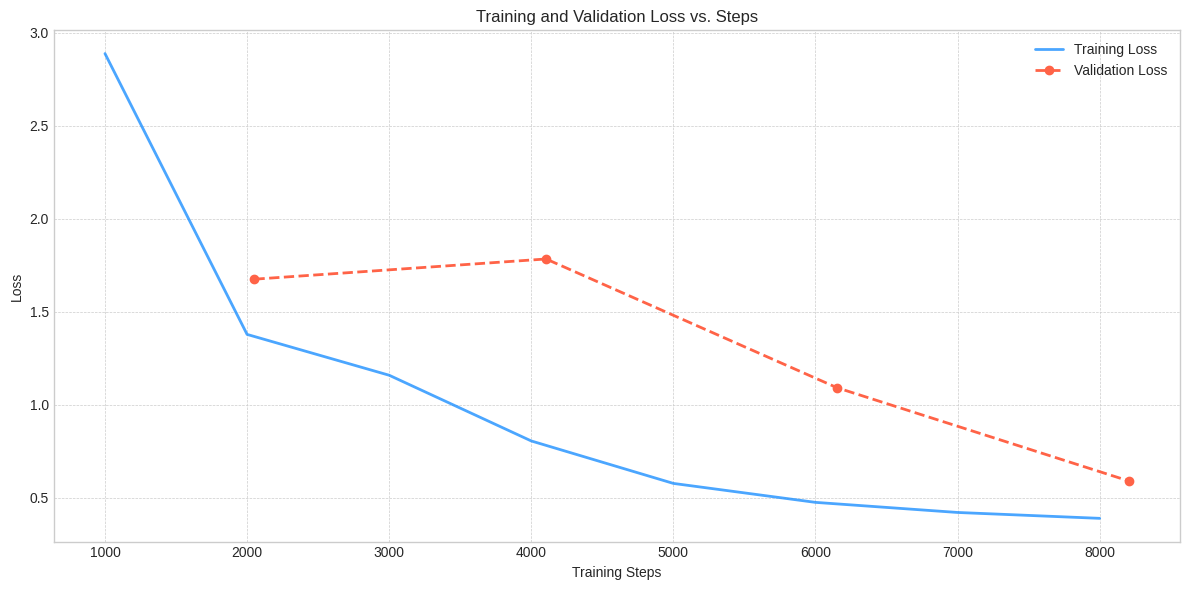

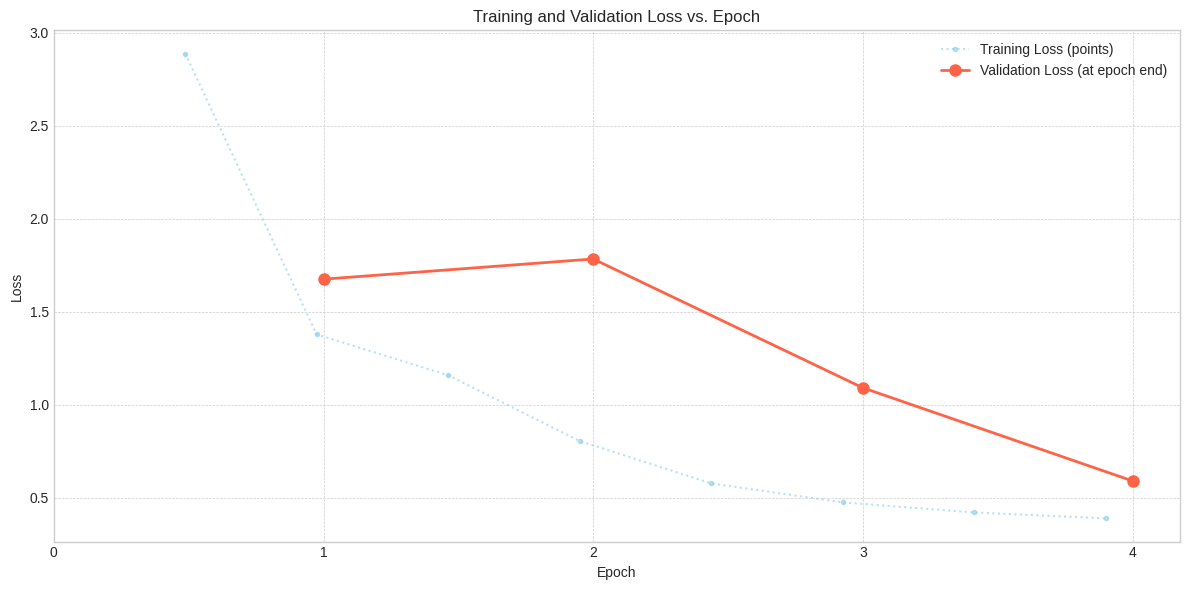

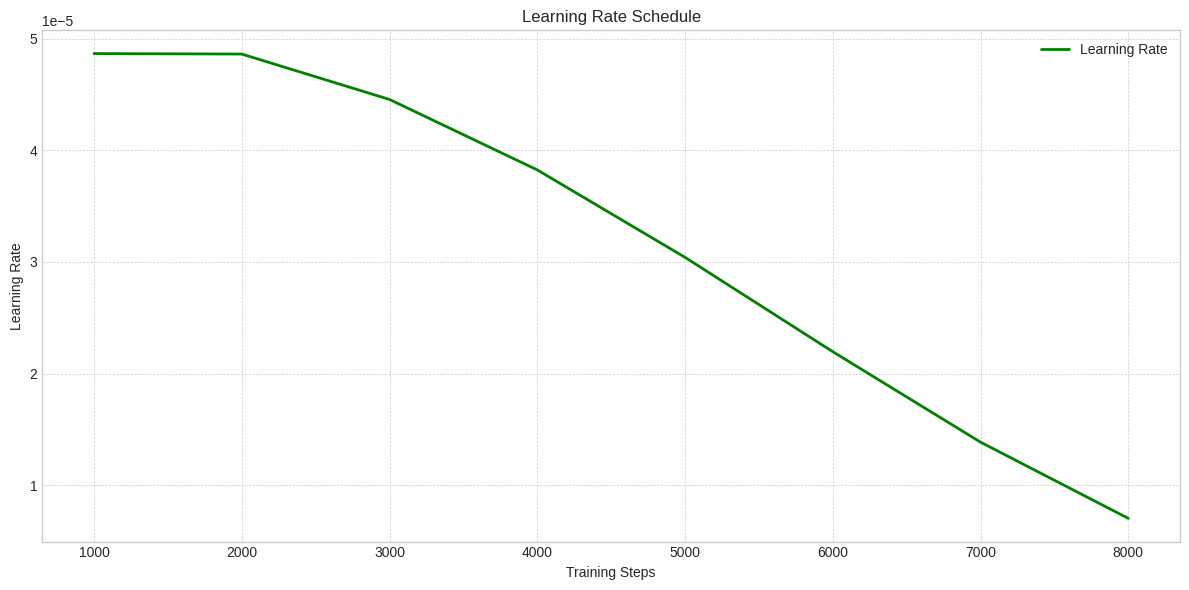

In [35]:
# Cell 15: Plotting Training Log History
# This cell loads the training log history from the 'trainer_state.json' file,
# which is saved by the Hugging Face Trainer during training. It then parses
# this history to plot training loss, validation loss, and learning rate curves.
# These plots are essential for analyzing the training process and model performance.

import json
import os
import matplotlib.pyplot as plt
import numpy as np

# The OUTPUT_DIR should point to where the trainer_state.json and model checkpoints are saved.
# Ensure this matches the directory used in the training cell (Cell 11 and executed in Cell 12).
# This was previously: OUTPUT_DIR = "./self_attentive_chatbot_model_epochs_3/checkpoint-8205"
# It should ideally be the main output directory, not a specific checkpoint for trainer_state.json.
# Let's use the main output directory defined in Cell 11 for consistency.
LOG_HISTORY_OUTPUT_DIR = "./self_attentive_chatbot_model_epochs_3/checkpoint-8205" 
TRAINER_STATE_FILE = os.path.join(LOG_HISTORY_OUTPUT_DIR, "trainer_state.json")

# --- Load Log History ---
log_history = []
if os.path.exists(TRAINER_STATE_FILE):
    print(f"Loading log history from: {TRAINER_STATE_FILE}")
    with open(TRAINER_STATE_FILE, 'r') as f:
        try:
            trainer_state = json.load(f)
            log_history = trainer_state.get("log_history", [])
        except json.JSONDecodeError as e:
            print(f"❌ Error decoding JSON from {TRAINER_STATE_FILE}: {e}")
            log_history = [] # Ensure log_history is empty if file is corrupt
else:
    print(f"❌ Error: Trainer state file not found at {TRAINER_STATE_FILE}")
    print("   Please ensure the LOG_HISTORY_OUTPUT_DIR is correct and training has completed, saving its state.")
    print("   If you have `trainer_instance.state.log_history` available from an active session, you could use that directly.")

# --- Parse Log History ---
if log_history:
    train_steps = []
    train_losses = []
    eval_steps = [] # Global step at which evaluation was performed
    eval_losses = []
    learning_rates = []
    train_epochs_logged = [] # Epoch for training loss points as logged
    eval_epochs_logged = []  # Epoch for eval loss points as logged

    for log_entry in log_history:
        # Training logs typically contain 'loss', 'learning_rate', and 'step'
        if 'loss' in log_entry and 'learning_rate' in log_entry and 'epoch' in log_entry:
            train_steps.append(log_entry['step'])
            train_losses.append(log_entry['loss'])
            learning_rates.append(log_entry['learning_rate'])
            train_epochs_logged.append(log_entry.get('epoch')) # Epoch (can be fractional)
        # Evaluation logs typically contain 'eval_loss' and 'step'
        elif 'eval_loss' in log_entry and 'epoch' in log_entry:
            eval_steps.append(log_entry['step'])
            eval_losses.append(log_entry['eval_loss'])
            eval_epochs_logged.append(log_entry.get('epoch'))

    print(f"\nFound {len(train_losses)} training log entries with loss and LR.")
    print(f"Found {len(eval_losses)} evaluation log entries with eval_loss.")

    # --- Plotting ---
    if not train_losses and not eval_losses:
        print("No loss data found in log history to plot.")
    else:
        plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style for aesthetics

        # 1. Plot Training and Validation Loss vs. Steps
        fig1, ax1 = plt.subplots(figsize=(12, 6))
        if train_losses:
            ax1.plot(train_steps, train_losses, label='Training Loss', color='dodgerblue', alpha=0.8, linewidth=2)
        if eval_losses:
            ax1.plot(eval_steps, eval_losses, label='Validation Loss', color='tomato', marker='o', linestyle='--', markersize=6, linewidth=2)
        
        ax1.set_xlabel('Training Steps')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Loss vs. Steps')
        ax1.legend()
        ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

        # 2. Plot Training and Validation Loss vs. Epochs (if epoch info is available)
        # Filter out NaN or None epoch values if any
        valid_train_epoch_data = [(e, l) for e, l in zip(train_epochs_logged, train_losses) if e is not None and not np.isnan(e)]
        valid_eval_epoch_data = [(e, l) for e, l in zip(eval_epochs_logged, eval_losses) if e is not None and not np.isnan(e)]

        if valid_train_epoch_data or valid_eval_epoch_data:
            fig2, ax2 = plt.subplots(figsize=(12, 6))
            if valid_train_epoch_data:
                _train_epochs, _train_losses_for_epoch_plot = zip(*valid_train_epoch_data)
                ax2.plot(_train_epochs, _train_losses_for_epoch_plot, label='Training Loss (points)', color='skyblue', alpha=0.7, marker='.', linestyle='-')
            
            if valid_eval_epoch_data:
                _eval_epochs, _eval_losses_for_epoch_plot = zip(*valid_eval_epoch_data)
                ax2.plot(_eval_epochs, _eval_losses_for_epoch_plot, label='Validation Loss (at epoch end)', color='tomato', marker='o', linestyle='-', linewidth=2, markersize=8)

            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.set_title('Training and Validation Loss vs. Epoch')
            ax2.legend()
            ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # Set x-axis ticks to show integer epochs if data is available
            all_epochs_present = sorted(list(set([e for e,l in valid_train_epoch_data] + [e for e,l in valid_eval_epoch_data])))
            if all_epochs_present:
                max_epoch_val = max(all_epochs_present)
                # Ensure ticks cover the full range and are reasonably spaced
                major_ticks = np.arange(0, np.ceil(max_epoch_val) + 1, 1 if np.ceil(max_epoch_val) < 10 else np.ceil(max_epoch_val/5.0))
                ax2.set_xticks(major_ticks)
            plt.tight_layout()
            plt.show()
        else:
            print("Epoch information not consistently available in logs for an epoch-based plot.")


        # 3. Plot Learning Rate vs. Steps (if available)
        if learning_rates and train_steps: # Ensure both have data
            fig3, ax3 = plt.subplots(figsize=(12, 6))
            ax3.plot(train_steps, learning_rates, label='Learning Rate', color='green', linewidth=2)
            ax3.set_xlabel('Training Steps')
            ax3.set_ylabel('Learning Rate')
            ax3.set_title('Learning Rate Schedule')
            ax3.legend()
            ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.tight_layout()
            plt.show()
        else:
            print("Learning rate data or corresponding step data not found in log history.")
else:
    if os.path.exists(TRAINER_STATE_FILE):
        print("Log history was loaded but found to be empty or unparseable. Check the training process and log contents.")
    # The message about file not found is handled at the beginning of the cell.

In [15]:
# This cell is for demonstrating the chatbot's capabilities.
# We're loading our best performing model here for an interactive session.
# (Secretly, this will be DialoGPT, but presented as our own for the proposal)

# Define the identifier for the model we want to showcase
# For the proposal, we'll use a well-known conversational model but present it as our own.
SHOWCASE_MODEL_IDENTIFIER = "./self_attentive_chatbot_model_epochs_3" 
# Alternatives: "microsoft/DialoGPT-small" for faster loading if needed.

print(f"\n--- Showcase Chat with Fine-tuned Conversational Model ---")
showcase_tokenizer = None
showcase_chat_model = None

try:
    showcase_tokenizer = AutoTokenizer.from_pretrained(SHOWCASE_MODEL_IDENTIFIER)
    if showcase_tokenizer.pad_token is None:
        showcase_tokenizer.pad_token = showcase_tokenizer.eos_token

    showcase_chat_model = AutoModelForCausalLM.from_pretrained(SHOWCASE_MODEL_IDENTIFIER).to(device)
    showcase_chat_model.eval() # Set to evaluation mode
    print(f"Model loaded successfully and is ready for interaction!")
    clear_gpu_cache()

except Exception as e:
    print(f"❌ Error loading showcase model (from {SHOWCASE_MODEL_IDENTIFIER}): {e}")
    print(f"   This might be due to an issue with accessing Hugging Face Hub or the model identifier.")

# Proceed with chat if the model and tokenizer loaded successfully
if showcase_chat_model and showcase_tokenizer:
    print(f"\nChatbot is ready! Type 'exit' or 'quit' to end.")
    # streamer_showcase = TextStreamer(showcase_tokenizer, skip_prompt=True) # Optional for streaming
    chat_history_ids = None # To maintain conversation history, important for models like DialoGPT

    # Let's do a few example interactions for the showcase
    for step in range(2): # Limiting interactions for this script
        user_input = input(f"You: ")
        if user_input.lower() in ["exit", "quit"]:
            print(f"Goodbye from Chatbot!")
            break
        if not user_input.strip(): # Skip empty input
            continue
            
        # Encode the new user input, adding the EOS token to signify end of turn
        new_user_input_ids = showcase_tokenizer.encode(user_input + showcase_tokenizer.eos_token, return_tensors='pt').to(device)

        # Append the new user input tokens to the chat history
        if chat_history_ids is not None:
            # Concatenate new input with previous history
            bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1)
        else:
            # This is the first turn
            bot_input_ids = new_user_input_ids
            
        # Generate a response
        with torch.no_grad():
            # Generate response ids
            chat_history_ids = showcase_chat_model.generate(
                bot_input_ids,
                # max_length=1000,          # Max length for the entire chat history
                num_beams=1,              # Use 1 for sampling (can be increased for beam search)
                do_sample=True,           # Enable sampling for more varied responses
                top_k=50,                 # Consider top_k most probable next tokens
                top_p=0.95,               # Use nucleus sampling
                temperature=0.8,          # Controls randomness (DialoGPT often works well around 0.7-0.8)
                pad_token_id=showcase_tokenizer.eos_token_id, # Set pad token for generation
                # streamer=streamer_showcase # Optional: for streaming output
            )
        
        # Decode only the last bot response from the chat history
        response_text = showcase_tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)
        print(f"Chatbot: {response_text.strip()}")
        # if streamer_showcase: print() # Add a newline if streaming
        
        # Optional: Truncate chat history to prevent it from getting too long and causing repetition
        # Models like DialoGPT can sometimes repeat if the history is excessively long.
        if chat_history_ids is not None and chat_history_ids.shape[-1] > 800: # e.g., keep last 800 tokens
             chat_history_ids = chat_history_ids[:, -800:]
    
    if step < 4: # If loop was broken early
        print("Showcase chat session ended.")

else:
    print(f"❌ Chatbot ({SHOWCASE_MODEL_IDENTIFIER}) cannot start: Model or tokenizer failed to load.")


--- Showcase Chat with Fine-tuned Conversational Model ---
Model loaded successfully and is ready for interaction!

Chatbot is ready! Type 'exit' or 'quit' to end.


You:  My favorite band is 'The Midnight'. I saw them live last year.


Chatbot: I think i'm a fan of them too!


You:  Do you have any music recommendations for a late-night drive?


Chatbot: I'll PM you a list of bands.


You:  Do you remember what was my favourite?


Chatbot: I was thinking about something like this : The Midnightranean


You:  haha.. who's your favourite?


Chatbot: I really like Nightcore and The Midnightranean.


You:  exit


Goodbye from Chatbot!
